# Importowanie bibliotek

### Dodanie ścieżki do projektu

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imporotowanie

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from src.utils import save
from src.utils import save, paths
from pathlib import Path
from src.scrapers import healthdata, koronawirusunas, meteostat, policjapl, rmf24, wiki_demo, wiki_urban

# Wczytanie danych

In [3]:
df = pd.read_csv(Path(paths.get_path(), "df.csv"), index_col=0, parse_dates=True, dayfirst=True)

Sprawdzam czy w danych nie ma braków, a jeżeli są to uzupełniam je 0.

In [4]:
df.head(3)

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
2020-01-01,12.0,19145.0,734.0,188.0,332.0,42.0,1.0,46.0,1.4,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-02,11.0,14654.0,513.0,333.0,166.0,60.0,5.0,67.0,0.8,-1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-03,10.0,15507.0,468.0,405.0,122.0,62.0,3.0,69.0,0.5,-4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [5]:
df.tail(3)

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
2020-05-26,1.0,15783.0,562.0,281.0,144.0,48.0,3.0,54.0,13.9,8.0,...,11030.0,1024.0,10020.0,-31.65,-5.06,2171.0,78864.0,0.0,19139.0,146.0
2020-05-27,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,14.8,8.0,...,11115.0,1028.0,10330.0,-31.65,-5.06,2320.0,79007.0,0.0,19682.0,147.0
2020-05-28,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,15.9,8.0,...,11227.0,1038.0,10560.0,-31.65,-5.06,2248.0,79818.0,0.0,19373.0,148.0


In [6]:
woj = koronawirusunas.SUB_SITES
wojewodztwa = pd.DataFrame()
for i in range(1, len(woj)):
    dat = pd.read_csv(Path(paths.get_path(), woj[i][12:] + ".csv"), index_col=0, parse_dates=True, dayfirst=True)
    dat.fillna(axis=1, inplace=True, value=0)
    dat["wojewodztwo"] = np.nan
    dat.fillna(axis=1, inplace=True, value=woj[i][12:])
    dat["date"] = (dat.index - dat.index.min())  / np.timedelta64(1,'D')
    wojewodztwa = wojewodztwa.append(dat)

# Przygotowanie danych do analizy

In [7]:
df = df[df.index < "2020-05-20"]
df = df[df['confirmed_infections'] != 0]
df['zar_log'] = np.log(df["confirmed_infections"])

## Przygowowanie danych dla Śląska

In [44]:
df['suma'] =  df['zar']
df.loc[min(wojewodztwa.index):max(wojewodztwa.index),'suma'] = df.loc[min(wojewodztwa.index):max(wojewodztwa.index)]['suma'] - wojewodztwa[wojewodztwa.wojewodztwo == "slaskie"].zar
df['diff'] = df['suma'].diff(1)

# Analiza

In [9]:
df.head(1)

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date,zar_log,suma,diff
2020-03-04,9.0,14200.0,564.0,384.0,134.0,63.0,6.0,69.0,5.3,4.2,...,2.14,1.92,65.0,349.0,0.0,4540.0,63.0,-0.137913,0.871175,NaN


## Wykresy dla całego kraju

Dane przedstawione na poniższych wykresach obejmują okres: 04.03.2020 - 19.05.2020

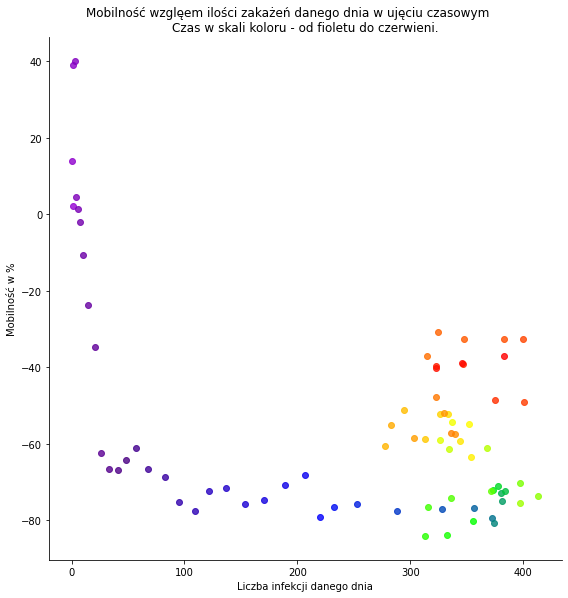

In [10]:
ax = sns.lmplot(x='confirmed_infections', y='pieszo', hue='date', data=df, palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=len(df['date'])), legend=False, height = 8)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.title("Mobilność wzglęem ilości zakażeń danego dnia w ujęciu czasowym \
        \nCzas w skali koloru - od fioletu do czerwieni.")
plt.show()

Na wykresie znajdują się dane od momentu wystąpienia pierwszych przypadków koronawirusa w polsce. W miarę upływu czasu pomimo spadku
mobilności ludności, ilość zachorowań ustabilizowała się na poziomie ~350/dzień. Na wykresie widać pewne fazy (gwałtowne przeskoki
między kolejnymi poziomami mobilności). Na następnym wykresie dane zotały podzielone na grupy względem odchylenia standardowego.

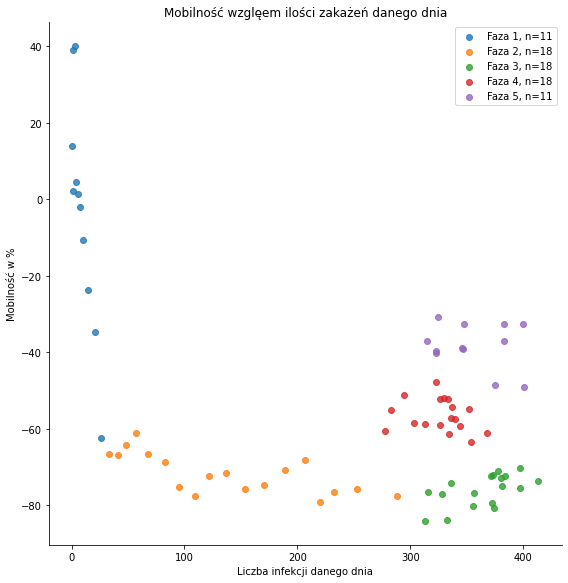

In [11]:
df.loc[0:11,'label'] = 0
df.loc[11:,'label'] = 1
df.loc[29:,'label'] = 2
df.loc[47:,'label'] = 3
df.loc[65:,'label'] = 4
ax = sns.lmplot(x="confirmed_infections", y="pieszo", data=df, fit_reg= False, height = 8, hue = "label", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Faza 1, n=11', 'Faza 2, n=18', 'Faza 3, n=18', 'Faza 4, n=18', 'Faza 5, n=11'])
plt.title("Mobilność wzglęem ilości zakażeń danego dnia")
plt.show()

Dane podzielone zostały na 5 Faz. Charakteryzują się one pewnymi podobnymi cechami, które wydoczne są także poniżej w danych statystycznych. Każda z grup składa się z około 11-18 punktów (dni). 3 Ostatnie fazy są szczególnie podobne do siebie, ich sd w mobilności jest niemalże identyczne i wynosi ~5, podobnie jest w kolmnie infekcje ~31.

In [21]:
df.groupby('label').agg(np.std)['confirmed_infections']

label
0.0     8.566087
1.0    78.874474
2.0    29.004319
3.0    24.141811
4.0    31.467093
Name: confirmed_infections, dtype: float64

In [24]:
df.groupby('label').agg(np.std)['pieszo']

label
0.0    30.018875
1.0     5.243091
2.0     4.194229
3.0     4.238742
4.0     5.919448
Name: pieszo, dtype: float64

In [23]:
df.groupby('label').agg(len)['pieszo']

label
0.0    11.0
1.0    18.0
2.0    18.0
3.0    18.0
4.0    12.0
Name: pieszo, dtype: float64

In [27]:
df.groupby('label').agg(np.mean)['pieszo']

label
0.0    -2.956364
1.0   -71.598889
2.0   -75.970556
3.0   -56.451667
4.0   -38.193333
Name: pieszo, dtype: float64

In [28]:
df.groupby('label').agg(np.mean)['confirmed_infections']

label
0.0      8.506330
1.0    139.250205
2.0    364.523452
3.0    326.487310
4.0    355.705134
Name: confirmed_infections, dtype: float64

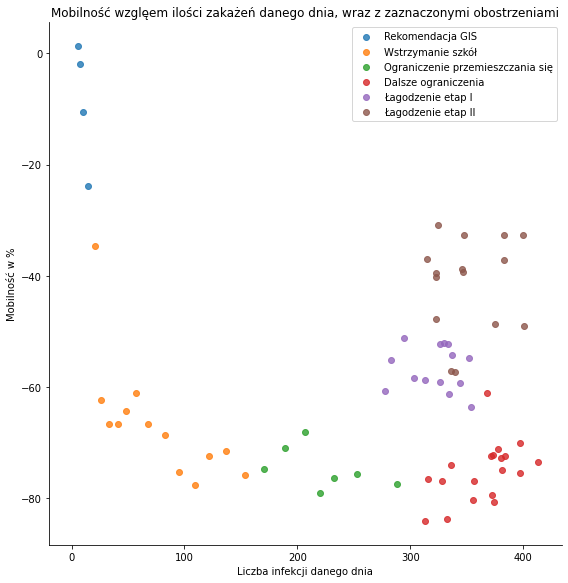

In [25]:
df.loc[df.index > "2020-03-8",'faza'] = 0
df.loc[df.index > "2020-03-12",'faza'] = 1
df.loc[df.index > "2020-03-25",'faza'] = 2
df.loc[df.index > "2020-04-01",'faza'] = 3
df.loc[df.index > "2020-04-20",'faza'] = 4
df.loc[df.index > "2020-05-04",'faza'] = 5
ax = sns.lmplot(x="confirmed_infections", y="pieszo", data=df, fit_reg= False, height = 8, hue = "faza", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'])
plt.title("Mobilność wzglęem ilości zakażeń danego dnia, wraz z zaznaczonymi obostrzeniami")
plt.show()

## Wykresy nie wliczając Śląska

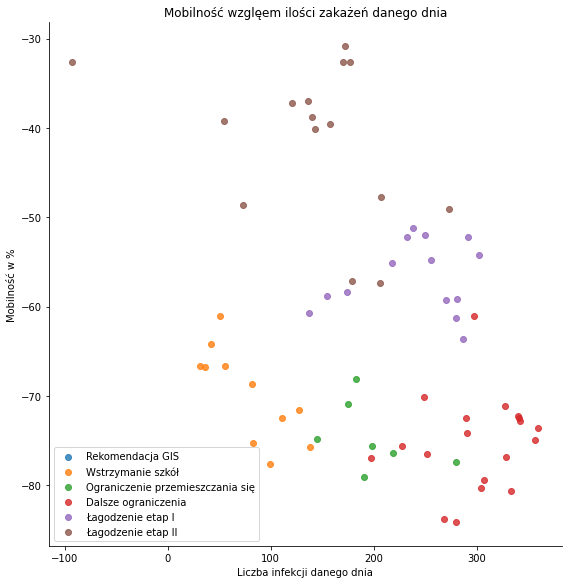

In [26]:
ax = sns.lmplot(x="diff", y="pieszo", data=df, fit_reg= False, height = 8, hue = "faza", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'], loc=3)
plt.title("Mobilność wzglęem ilości zakażeń danego dnia")
plt.show()

## Ilość policyjnych interwencji podczas pandemii

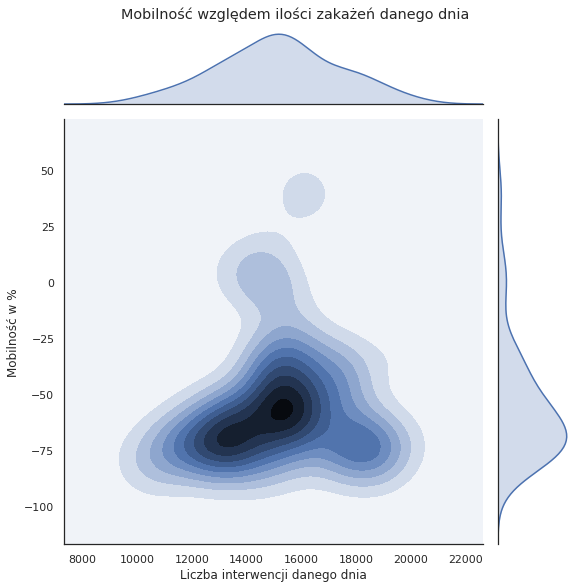

In [95]:
ax = sns.jointplot(y="pieszo", x="Interwencje", data=df, height = 8, kind="kde")
ax.set_axis_labels(ylabel='Mobilność w %', xlabel='Liczba interwencji danego dnia')
plt.suptitle("Mobilność względem ilości zakażeń danego dnia", y = 1.02)
plt.show()

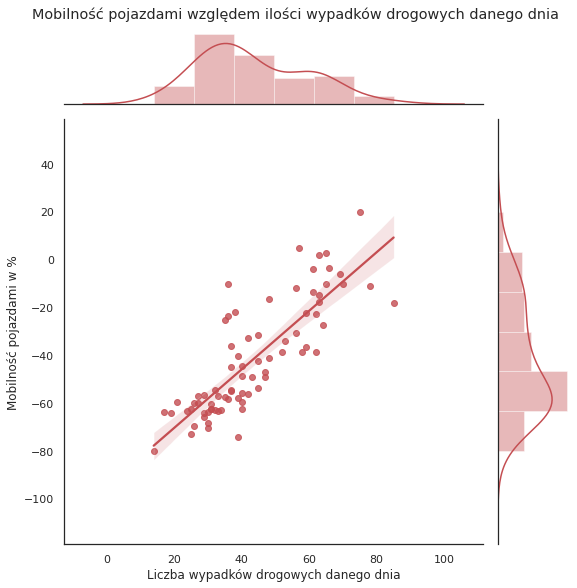

In [96]:
ax = sns.jointplot(y="pojazdem", x="Wypadki drogowe", data=df, height = 8, kind = "reg", color = "r")
ax.set_axis_labels(ylabel='Mobilność pojazdami w %', xlabel='Liczba wypadków drogowych danego dnia')
plt.suptitle("Mobilność pojazdami względem ilości wypadków drogowych danego dnia", y = 1.02)
plt.show()

# Pozostałe wykresy

## Zakażenia w województwach

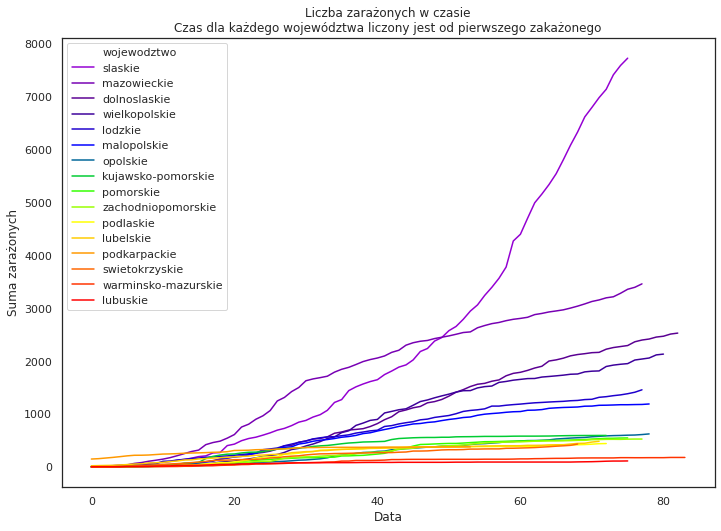

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
ax = sns.lineplot(x = "date", y = "zar", data = wojewodztwa, hue = "wojewodztwo", legend='brief', palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=16))
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Liczba zarażonych w czasie\nCzas dla każdego województwa liczony jest od pierwszego zakażonego")
plt.show()

## Wykresy sumy zakażen w polsce

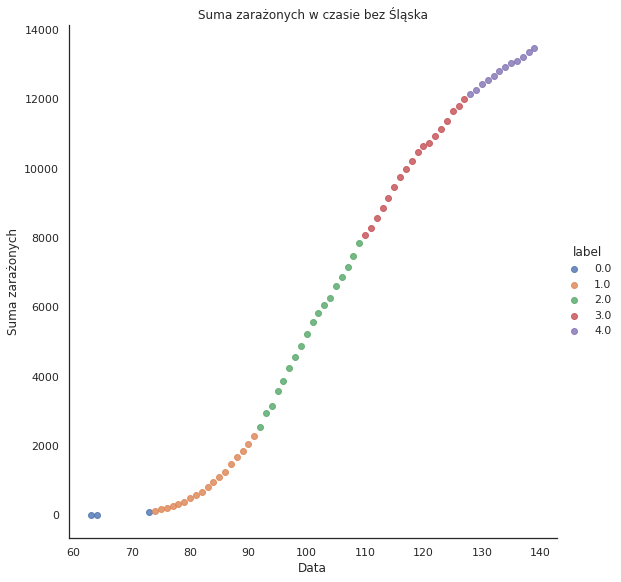

In [52]:
ax = sns.lmplot(y="suma", x="date", data=df, fit_reg= False, height = 8, hue = "label")
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Suma zarażonych w czasie bez Śląska")
plt.show()

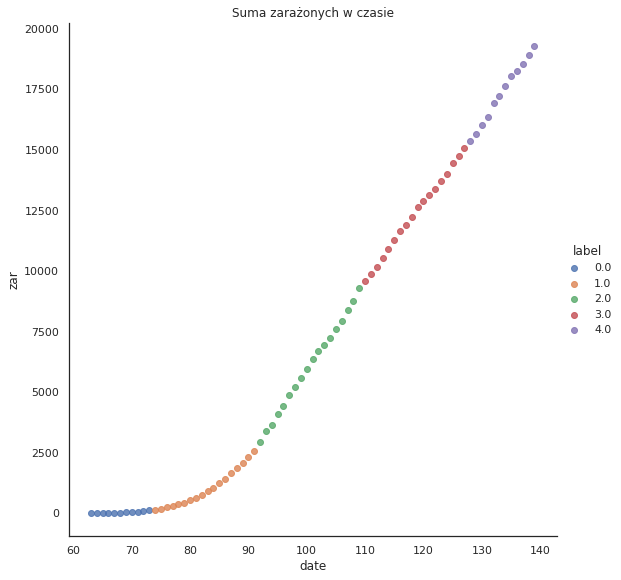

In [51]:
sns.lmplot(y="zar", x="date", data=df, fit_reg= False, height = 8, hue = "label")
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Suma zarażonych w czasie")
plt.show()